# In order to start on this project, please download the data set from
# https://zenodo.org/record/4048312#.YDjKw-oo9H5

#Iteration 2

#Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
from functools import reduce
from collections import Counter
from keras.layers import *
import numpy as np
import pandas
from sklearn.ensemble import VotingClassifier
# import wavencoder
import pickle
# import librosa
# import malaya_speech
# from malaya_speech import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as ipd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import CuDNNLSTM
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam # - Works
from keras.layers import Attention
from keras.layers import Activation
from keras.layers import ELU
from keras.layers import TimeDistributed 
from keras import regularizers
from keras import initializers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# import sklearn_relief as relief

import tensorflow as tf
import cv2
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import keras.backend as K

Mounted at /content/drive


#**Reading Data**

In [2]:
def getMFCCs(padding_length = 512, outliers = 500, reshape_length = 20):

# convert a string of mfccs into floating points
  def convertFloat(features):
    feat = []
    f = features.split(",")
    for fe in f:
      feat.append(float(fe))
    return feat

# split the string on the basis of delimeter
  def Read_Split(mfccs):
    features = mfccs.split('=')
    feat = []
    for feature in features:
      feat.append(convertFloat(feature))
    return feat

# reading and splittting the mfccs
  def readMFCCS():
    file = open("/content/drive/My Drive/FYP/MFCCs.txt", 'r').readlines()
    mfccs = []
    labels = []
    input_files = []
    for lines in file:
      param = lines.split("|")
      input_files.append(param[0])
      features = param[1]
      lable = param[2][:-1]
      mfccs.append(Read_Split(features))
      if 'healthy' in lable:
        labels.append(0)
      else:
        labels.append(1)
      del lable
      del param
    return mfccs, labels, input_files
# padding the mfccs to the padding_length that is initially set to 512
  def pad(X, padding_length):
    while len(X) != padding_length:
      X.append(0.0)
    return np.array(X)
  def do_padding(mfcc, padding_length):
    new_mfcc = []
    for mf in mfcc:
      new_mfcc.append(pad(mf, padding_length))
    return np.array(new_mfcc)

# return flattened np arrays 
  def getFlattened(X):
    new_mfcc = []
    for mfcc in X:
      new_mfcc.append(np.array(mfcc).flatten().tolist())
    return new_mfcc
  

# delete outliers, 
# first we sort the values and then the first N number of outliers and the last N 
# number of outliers are deleted
  def deleteOutliers(newX, input_files ,X, y, outliers, reshape_length):
    alpha = sorted(newX, key = len)
    for i in range(0, outliers):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    for i in range(len(alpha)-outliers - 1 ,len(alpha)-1):
      index = X.index(np.array(alpha[i]).reshape(reshape_length, -1).tolist())
      del (X[index])
      del (y[index])
      del input_files[index]
    return X, y

  def applyPad(X, padding_length):
    newX = []
    for mfcc in X:
      newX.append(do_padding(mfcc, padding_length).flatten())
    return newX
  def get_segmented(X):
    newX = []
    for mfcc in X:
      newX.append(mfcc)
    return newX

  X, y, input_files = readMFCCS()
  newX = getFlattened(X)
  X, y = deleteOutliers(newX,input_files, X, y, outliers, reshape_length)
  X = get_segmented(X)
  X = applyPad(X, padding_length)
  del newX
  return X, y, input_files


In [3]:
def getSpecs(path):

  def stringtofloat(s):
    s_l = s.split('|')
    string = s_l[0]
    label = s_l[1]
    del s_l
    floating_points = string.split('_')
    array = []
    for fp in floating_points:
      array.append(float(fp))
    return array, label
  def pad(X):
    while len(X) != 512:
      X.append(0.0)
    return np.array(X)

  def doPad(X):
    newX = []
    for xx in X:
      newX.append(pad(xx))
    return np.array(newX)
  def readfeatures(path):
    sp = open(path, 'r')
    X = []
    y = []
    for lines in sp:
      array, label = stringtofloat(lines)
      X.append(array)
      if "healthy" in label:
        y.append(0)
      else:
        y.append(1)
      del array
      del label
    return X, y
  # Removing the bottom 100 and top 100 outliers. 
  # print(len(X), len(y))
  def deleteOutliers(X, y):
    alpha = sorted(X, key = len)
    for i in range(0, 100):
      index = X.index(alpha[i])
      del (X[index])
      del (y[index])
    for i in range(len(alpha)- 101, len(alpha)- 1):
      index = X.index(alpha[i])
      del (X[index])
      del (y[index])
    del alpha
    return X, y



  X, y = readfeatures(path)
  X, y = deleteOutliers(X, y)
  X = doPad(X)

  return X, y



***Apply Random Sampler first, and then SMOTE***

In [4]:
def OverSampling(X, Y):
  from imblearn.pipeline import Pipeline
  smote = SMOTE()
  randomSampler = RandomOverSampler()
  pipeline = Pipeline([ ('randomSampler', randomSampler), ('smote', smote)])
  return pipeline.fit_resample(X, Y)

*Getting Data*

In [5]:
def getData(path, which):
  if which == "SC":
    x_shape = 8 
    y_shape = 16 
    z_shape = 4
    X, y =getSpecs(path)
  else:
    x_shape = 160
    y_shape = 16 
    z_shape = 4
    X, y, input_files = getMFCCs()
  X = preprocessing.scale(preprocessing.normalize(X))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=1)
  X_train, y_train  = OverSampling(X_train, y_train)
  y_train = np.asarray(y_train)
  y_val = np.asarray(y_val)
  y_test = np.asarray(y_test)
  X_train = np.reshape(X_train, (X_train.shape[0], x_shape, y_shape, z_shape))
  X_val = np.reshape(X_val, (X_val.shape[0], x_shape, y_shape, z_shape))
  X_test = np.reshape(X_test, (X_test.shape[0], x_shape, y_shape, z_shape))
  return X_train, X_val, y_train, y_val, X_test, y_test, input_files, X

#Models


##Resnet50

In [6]:
from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)
def identity_block(X, f, filters, layer_id, blockid):
    
    layer_name = 'res' + str(layer_id) + blockid + 'br'
    bn_name_base = 'bn' + str(layer_id) + blockid + 'br'
    
    F1, F2, F3 = filters
    
    prev_X = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding =
               'valid', name = layer_name + 'identity_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding =
               'same', name = layer_name + 'identity_b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding =
               'valid', name = layer_name + 'identity_c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_c')(X)

    # Add shortcut value to main path
    X = Add()([prev_X, X])
    X = Activation('relu')(X)
        
    return X

In [7]:
def convolutional_block(X, f, filters, layer_id, block_id, s = 2):
        
    layer_name = 'res' + str(layer_id) + block_id + 'br'
    bn_name_base = 'bn' + str(layer_id) + block_id + 'br'
    F1, F2, F3 = filters
    prev_X = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = layer_name + 'identity_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding =
               'same', name = layer_name + 'identity_b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding =
               'valid', name = layer_name + 'identity_c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + 'identity_c')(X)
    prev_X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding =
                        'valid', name = layer_name + '1', kernel_initializer = glorot_uniform(seed=0))(prev_X)
    prev_X = BatchNormalization(axis = 3, name = bn_name_base + '1')(prev_X)
    X = Add()([prev_X, X])
    X = Activation('relu')(X)
   
    return X

In [8]:
def ResNet50( classes, input_shape):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((1, 1))(X_input)
    # X._estimator_type = "classifier"
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(1,1),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',top_5_accuracy])

    return model

##Get Model 1

In [9]:
def getModel1(input_shape):
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim = 10240))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics = ['acc'])
  return model

##Get Model 2

In [10]:
def getModel2(input_shape):
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim = 10240))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics = ['acc'])
  return model

##Getmodel3

In [11]:
def getModel3(input_dim):
    model = Sequential()
    # model._estimator_type = "classifier"
    model.add(Conv2D(32, kernel_size=(1, 3), padding='same', input_shape=(*input_dim, 4)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(32, kernel_size=(5, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 1)))
    model.add(Conv2D(64, kernel_size=(1, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(64, kernel_size=(5, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(5, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(128, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Conv2D(256, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(256, kernel_size=(5, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(256, kernel_size=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01), activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
    return model

##Getmodel4

In [12]:
def getModel4(input_dim):
    model = Sequential()
    # model._estimator_type = "classifier"
    model.add(Conv2D(32, kernel_size=(1, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros(), input_shape=(*input_dim, 4)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(32, kernel_size=(3, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(3, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(32, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.05), 
                     bias_initializer=initializers.Zeros()))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(Permute((2, 1, 3)))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(128, dropout=0.25, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.25, return_sequences=False)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.0001), activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, decay=1e-6), metrics=['accuracy'])
    model.summary()
    return model

#**Output of Models**

In [13]:
def plotModelHist(hist):
  print("Model's history Over the Epocs")
  sns.set()
  acc = hist.history['accuracy']
  val = hist.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()
def printConfusionMatrix(model, X_test, y_test):
  y_predicted = model.predict(X_test) > 0.5
  try:
    mat = confusion_matrix(y_test, y_predicted)
  except:
    res = []
    for i in range (len(y_predicted)):
      if y_predicted[i][0] == True:
        res.append(0)
      else:
        res.append(1)
    double = False
    y_predicted = res
    del res
    mat = confusion_matrix(y_test, y_predicted)
  labels = ['Positive', 'Negative']
  
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
              xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
  return y_predicted
def printEval(y_test, y_predicted):
  print("Test Accuracy: " , accuracy_score(y_test, y_predicted))
  print("F1 Score micro: ", f1_score(y_test, y_predicted, average='micro'))
  print("F1 Score weighted: ", f1_score(y_test, y_predicted, average='weighted'))
  print("Recall Micro: ",recall_score(y_test, y_predicted, average='micro'))
  print("Recall Weighted: ",recall_score(y_test, y_predicted, average='weighted'))



#Applying the model

In [14]:
def applyModel(input_dim, X_train, y_train, X_val, y_val):
  model = getModel1((160,16,4))
  hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=10, batch_size=32)
  return hist, model

## **Dumping** The model

In [15]:
def dumpModel(model):
  path = '/content/drive/My Drive/FYP/Models/'
  pickle.dump(model, open(path + input() + '.sav', 'wb'))
def loadModel(path):
  return pickle.load(open(path, 'rb'))

# dumpModel(model)

#*Implementing the code*

Saving Keras model

In [ ]:
# resnet50 = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/saved_model/my_model', custom_objects={'top_5_accuracy':top_5_accuracy})

# # Check its architecture
# new_model.summary()

Training the model

In [ ]:
hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=30, batch_size=32)

Loading Data

In [ ]:
X_train, X_val, y_train, y_val, X_test, y_test, files, X = getData("/content/drive/My Drive/FYP/spectral_centroid.txt", 'mfcc')

Loading Different Models

In [ ]:
# model2 = loadModel('/content/drive/My Drive/FYP/Models/sequential_3_mfccs_90ACC.sav')
# model3 = loadModel('/content/drive/My Drive/FYP/Models/sequential_3_mfccs_96ACC.sav')
# sequential3_98ACC_500outlier = loadModel('/content/drive/My Drive/FYP/Models/sequential3-98ACC-500outlier.sav')
# resnet50 = tf.keras.models.load_model('/content/drive/My Drive/FYP/Models/saved_model/my_model', custom_objects={'top_5_accuracy':top_5_accuracy})

In [ ]:
#  model = getModel3((160, 16)) 

In [ ]:
# hist = model.fit(X_train, y_train , validation_data=(X_val, y_val), epochs=30, batch_size=32)

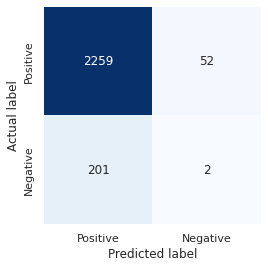

In [ ]:
model3_y = printConfusionMatrix(model, X_test, y_test)

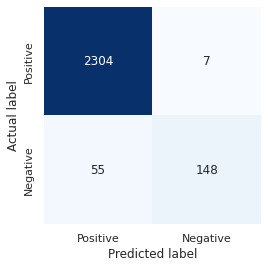

In [ ]:
model33Y = printConfusionMatrix(model3, X_test, y_test)

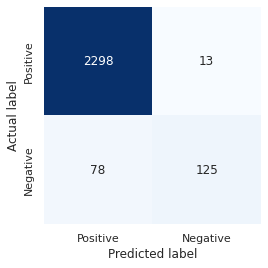

In [ ]:
model2Y = printConfusionMatrix(model2, X_test, y_test)

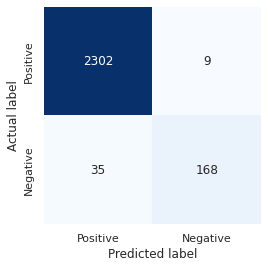

In [ ]:
sequential3_98ACC_500outlierYY =  printConfusionMatrix(sequential3_98ACC_500outlier, X_test, y_test)

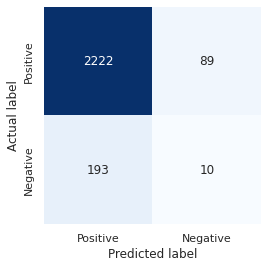

In [ ]:
resnet50y = printConfusionMatrix(resnet50, X_test, y_test)

In [ ]:
printEval(y_test, model2y_predicted)

Test Accuracy:  0.9638027048528242
F1 Score micro:  0.9638027048528242
F1 Score weighted:  0.960603810704936
Recall Micro:  0.9638027048528242
Recall Weighted:  0.9638027048528242


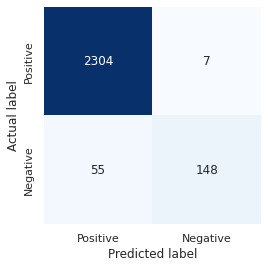

In [ ]:
model3y_predicted = printConfusionMatrix(model3, X_test, y_test)

In [ ]:
printEval(y_test, model3y_predicted)

Test Accuracy:  0.9753381066030231
F1 Score micro:  0.9753381066030231
F1 Score weighted:  0.9738115373784073
Recall Micro:  0.9753381066030231
Recall Weighted:  0.9753381066030231


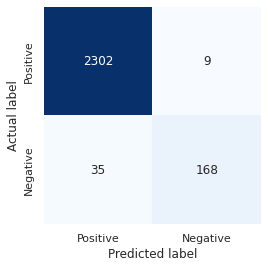

In [ ]:
sequential3_98ACC_500outliery_predicted = printConfusionMatrix(sequential3_98ACC_500outlier, X_test, y_test)

In [ ]:
printEval(y_test, sequential3_98ACC_500outliery_predicted)

Test Accuracy:  0.9824980111376292
F1 Score micro:  0.9824980111376292
F1 Score weighted:  0.98194821023286
Recall Micro:  0.9824980111376292
Recall Weighted:  0.9824980111376292


Majority Voting

Text(89.18, 0.5, 'Actual label')

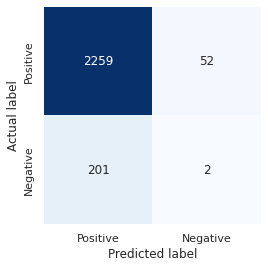

In [ ]:
mat = confusion_matrix(y_test, model333y)
labels = ['Positive', 'Negative']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:

model333y = []
for i in model3_y:
  if i == True:
    model333y.append(1)
  else:
    model333y.append(0)

In [ ]:
def returnMajorityVoted(resnet50y,sequential3_98ACC_500outlierYY,model3_y):
  final_y = []
  for a,b,c in zip(resnet50y,sequential3_98ACC_500outlierYY,model3_y):
    data = Counter([a,b,c])
    final_y.append(data.most_common(1)[0][0])
  return final_y
def printC(y_predicted):
  
  mat = confusion_matrix(y_test, y_predicted)
  labels = ['Positive', 'Negative']
  
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
              xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
final_y = returnMajorityVoted(resnet50y,sequential3_98ACC_500outlierYY,model333y)

In [ ]:
printEval(y_test, final_y)

Test Accuracy:  0.9200477326968973
F1 Score micro:  0.9200477326968973
F1 Score weighted:  0.8868002711278378
Recall Micro:  0.9200477326968973
Recall Weighted:  0.9200477326968973


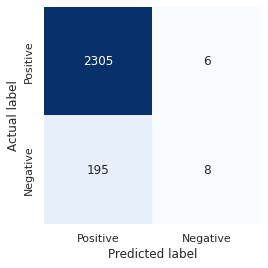

In [ ]:
printC(final_y)

#--------------------------------------------::::::::::------------------------------------------------------------------------:-